## Testing the halo_run catalog
#### Zhuowen Zhang; Created Oct. 10, 2018

Testing properties of the halo_run catalog and comparing it with the Chinchilla_unique catalog. 

### Initial setup

In [301]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

### Importing Halo Files

#### Halo_Run Catalog
Some notes about the catalog:
1. M200 refers to the Virial mass
2. 5e13 halos exclude subhalos which are filtered out by the halo exclusion algorithm in the ROCKSTAR finder, even if mass of subhalos are larger. That means halos are unlikely to be within ~R_vir of each other. 
3. Cuts of halo run are : lambda > 5, Mvir > 5e13, mask_frac >0.2. The mask_frac is not in the truth catalog, and may explain the mismatch in ID between halo_run and Chinchilla matched halos_redM
4. Bug: R200 same as M200

For consistency will convert the FITS data into a record array. That's more familiar to work with.

In [302]:
from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits
datadir = data_home_dir()
homedir = home_dir()
hrun_dir = datadir + 'halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto.fit'
hrun_list = fits.open(hrun_dir)
hrun_data = hrun_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in hrun_data are: \n"
print hrun_data.names

#Converting FITS files into record array
hrun_data = np.array(hrun_data, dtype=hrun_data.dtype)
hrun_data = hrun_data.view(np.recarray)

print "\n Number of halos is", len(hrun_data)

Names of columns in hrun_data are: 

['HALOID', 'M200', 'R200', 'MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'P_BCG', 'Z_LAMBDA', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'ra_cent', 'dec_cent', 'p_cen', 'p_sat', 'ID_CENT']

 Number of halos is 124403


#### redMaPPer matched halos from Chinchilla

In [304]:
#Read from redM_matched halos
homedir = home_dir()
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Field names of the files from first row of file. Shoule be:
#('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 
#'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
redM_halos = np.genfromtxt(redM_dir, dtype ="i, f8, f8, f8, f8, i, f8, f8, f8, f8, f8, f8, f8, f8, f8", \
                  unpack=True, usecols=range(0,15), names=True)
redM_halos = redM_halos.view(np.recarray)

print "Names of redM_matched halo column data are:"
print redM_halos.dtype.names, "\n"
print "Number of halos read is ", len(redM_halos)

Names of redM_matched halo column data are:
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir') 

Number of halos read is  23998


### Comparing halo_run vs. halo_redM_matched

#### Apply cuts
e.g. for matched_halos found in halo_run; or for clusters with MEM_MATCH_ID found in halo_run

In [305]:
#Apply mass cut
mass_lower = 5e13 #Msun/h

#Halo-run mass cut
mcut = np.where(hrun_data.M200 >= mass_lower)[0] #Again, M200 in hrun is actually Mvir
hrun_data_mcut = hrun_data[mcut]

#matched_halo mass cut
mcut = np.where(redM_halos.halos_M200b >= mass_lower)[0]
redM_halos_mcut = redM_halos[mcut]
                            
print "After mass cut:"
print "Number of halos in halo_run is ", len(hrun_data_mcut)
print "Number of halos in matched_halos is ", len(redM_halos_mcut)

After mass cut:
Number of halos in halo_run is  124403
Number of halos in matched_halos is  19967


#### Sanity check: Searching for identical halos. 

Check that 100% of halo_run in raw Chinchilla halo catalog.
Most redM-matched halos should be in the halo-run catalog. Missing are due to additional mask_frac cuts. 

In [306]:
halos_matched_bool = np.isin(redM_halos.halos_ID, hrun_data.HALOID)
halocut = np.where(halos_matched_bool == True)[0]
print "Before mass cut:"
print "Number of matched_halos in hrun is ", len(halocut), "out of ", len(redM_halos.halos_ID)

Before mass cut:
Number of matched_halos in hrun is  19172 out of  23998


In [307]:
halos_matched_bool = np.isin(redM_halos_mcut.halos_ID, hrun_data_mcut.HALOID)
halocut = np.where(halos_matched_bool == True)[0]
print "Before mass cut:"
print "Number of matched_halos in hrun is ", len(halocut), "out of ", len(redM_halos_mcut.halos_ID)

Before mass cut:
Number of matched_halos in hrun is  19172 out of  19967


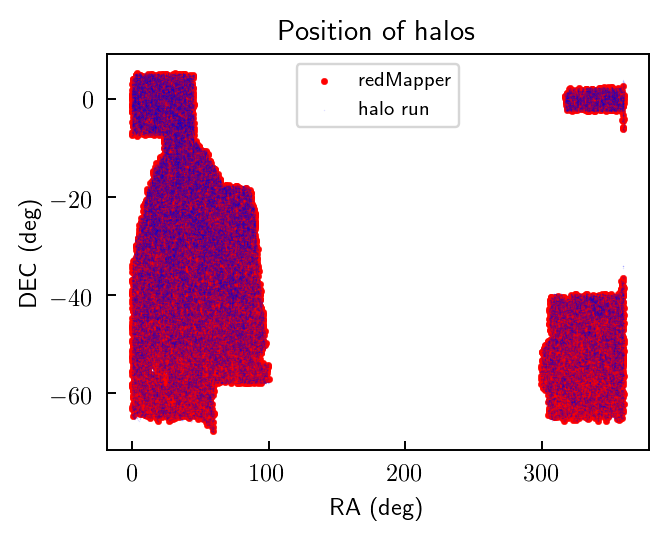

In [308]:
#Plotting in RA, DEC space
plt.figure(figsize=(4,3))
plt.scatter(redM_halos_mcut.halos_RA, redM_halos_mcut.halos_DEC, c='r', s=7, marker='o',linewidth=0.2, label='redMapper')
plt.scatter(hrun_data_mcut.RA, hrun_data_mcut.DEC, c='b', marker='.', s=1, linewidth=0.1, alpha=0.1, label='halo run')
plt.xlabel('RA (deg)'); plt.ylabel('DEC (deg)')
plt.legend(fontsize=8, loc='upper center')
plt.title('Position of halos')
#plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

### Halo matching

#### Match redM_halos onto hrun_halos by ID

In [309]:
halos_matched_bool = np.isin(redM_halos_mcut.halos_ID, hrun_data_mcut.HALOID)
halocut = np.where(halos_matched_bool == True)[0]
redM_halos_halocut = redM_halos_mcut[halocut]
print "Before halocut but after mass cut number of halos in redM_halos is ", len(redM_halos_mcut)
print "After halocut number of halos in redM_halos is ", len(redM_halos_halocut)

Before halocut but after mass cut number of halos in redM_halos is  19967
After halocut number of halos in redM_halos is  19172


#### Match redM_halos onto hrun_halos by ID
CDKTree for sorting by ID. 
$$
from scipy.spatial import cKDTree
hid_truth_2d = np.dstack([hid_truth,hid_truth])[0]  # needs to be 2D arrays
mytree = cKDTree(hid_truth_2d)  
dist, indexes = mytree.query(np.dstack([hid_halorun,hid_halorun])[0])
$$

In [310]:
halos_matched_bool = np.isin(hrun_data_mcut.HALOID, redM_halos_halocut.halos_ID)
halocut = np.where(halos_matched_bool == True)[0]
hrun_data_halocut = hrun_data[halocut]

#Halo_Run catalog has repeating halos. Clean that up
unique_ID, unique_ind = np.unique(hrun_data_halocut.HALOID, return_index=True)
hrun_data_halocut = hrun_data_halocut[unique_ind]

print "Before halocut but after mass cut number of halos in hrun is ", len(hrun_data_mcut)
print "After halocut number of halos in hrun is ", len(hrun_data_halocut)

Before halocut but after mass cut number of halos in hrun is  124403
After halocut number of halos in hrun is  19172


In [311]:
#Check that all IDs are one-to-one matched
ID_matched_bool = np.isin(redM_halos_halocut.halos_ID, hrun_data_halocut.HALOID)
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(redM_halos_halocut), "halos in redM_halos_halocut are in hrun_data_halocut"
ID_matched_bool = np.isin(hrun_data_halocut.HALOID, redM_halos_halocut.halos_ID)
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(hrun_data_halocut), "halos in hrun_data_halocut are in redM_halos_halocut"

After halocut  19172  out of  19172 halos in redM_halos_halocut are in hrun_data_halocut
After halocut  19172  out of  19172 halos in hrun_data_halocut are in redM_halos_halocut


#### Sorting by ID

In [312]:
#Sort the arrays by order of ID. That way the indices match. 

#For hrun
ID_sort = np.argsort(hrun_data_halocut.HALOID)
hrun_data_halocut = hrun_data_halocut[ID_sort]
print "After sorting, IDs in hrun are: "
print hrun_data_halocut.HALOID, "\n"

#For redM_halos
ID_sort = np.argsort(redM_halos_halocut.halos_ID)
redM_halos_halocut = redM_halos_halocut[ID_sort]
print "After sorting, IDs in redM_halos are: "
print redM_halos_halocut.halos_ID, "\n"

After sorting, IDs in hrun are: 
[   760306   2184825   2203138 ... 140447440 140449099 140450694] 

After sorting, IDs in redM_halos are: 
[   760306   2184825   2203138 ... 140447440 140449099 140450694] 



### halo_run vs. matched_halos
For outliers in mass: check redshift, lambda, RA, DEC. Compare two catalogs. 

Plot ratio of lambda vs miscentering distance. Expect large miscentering for ratio away from 1.

#### Mass and Lambda comparison

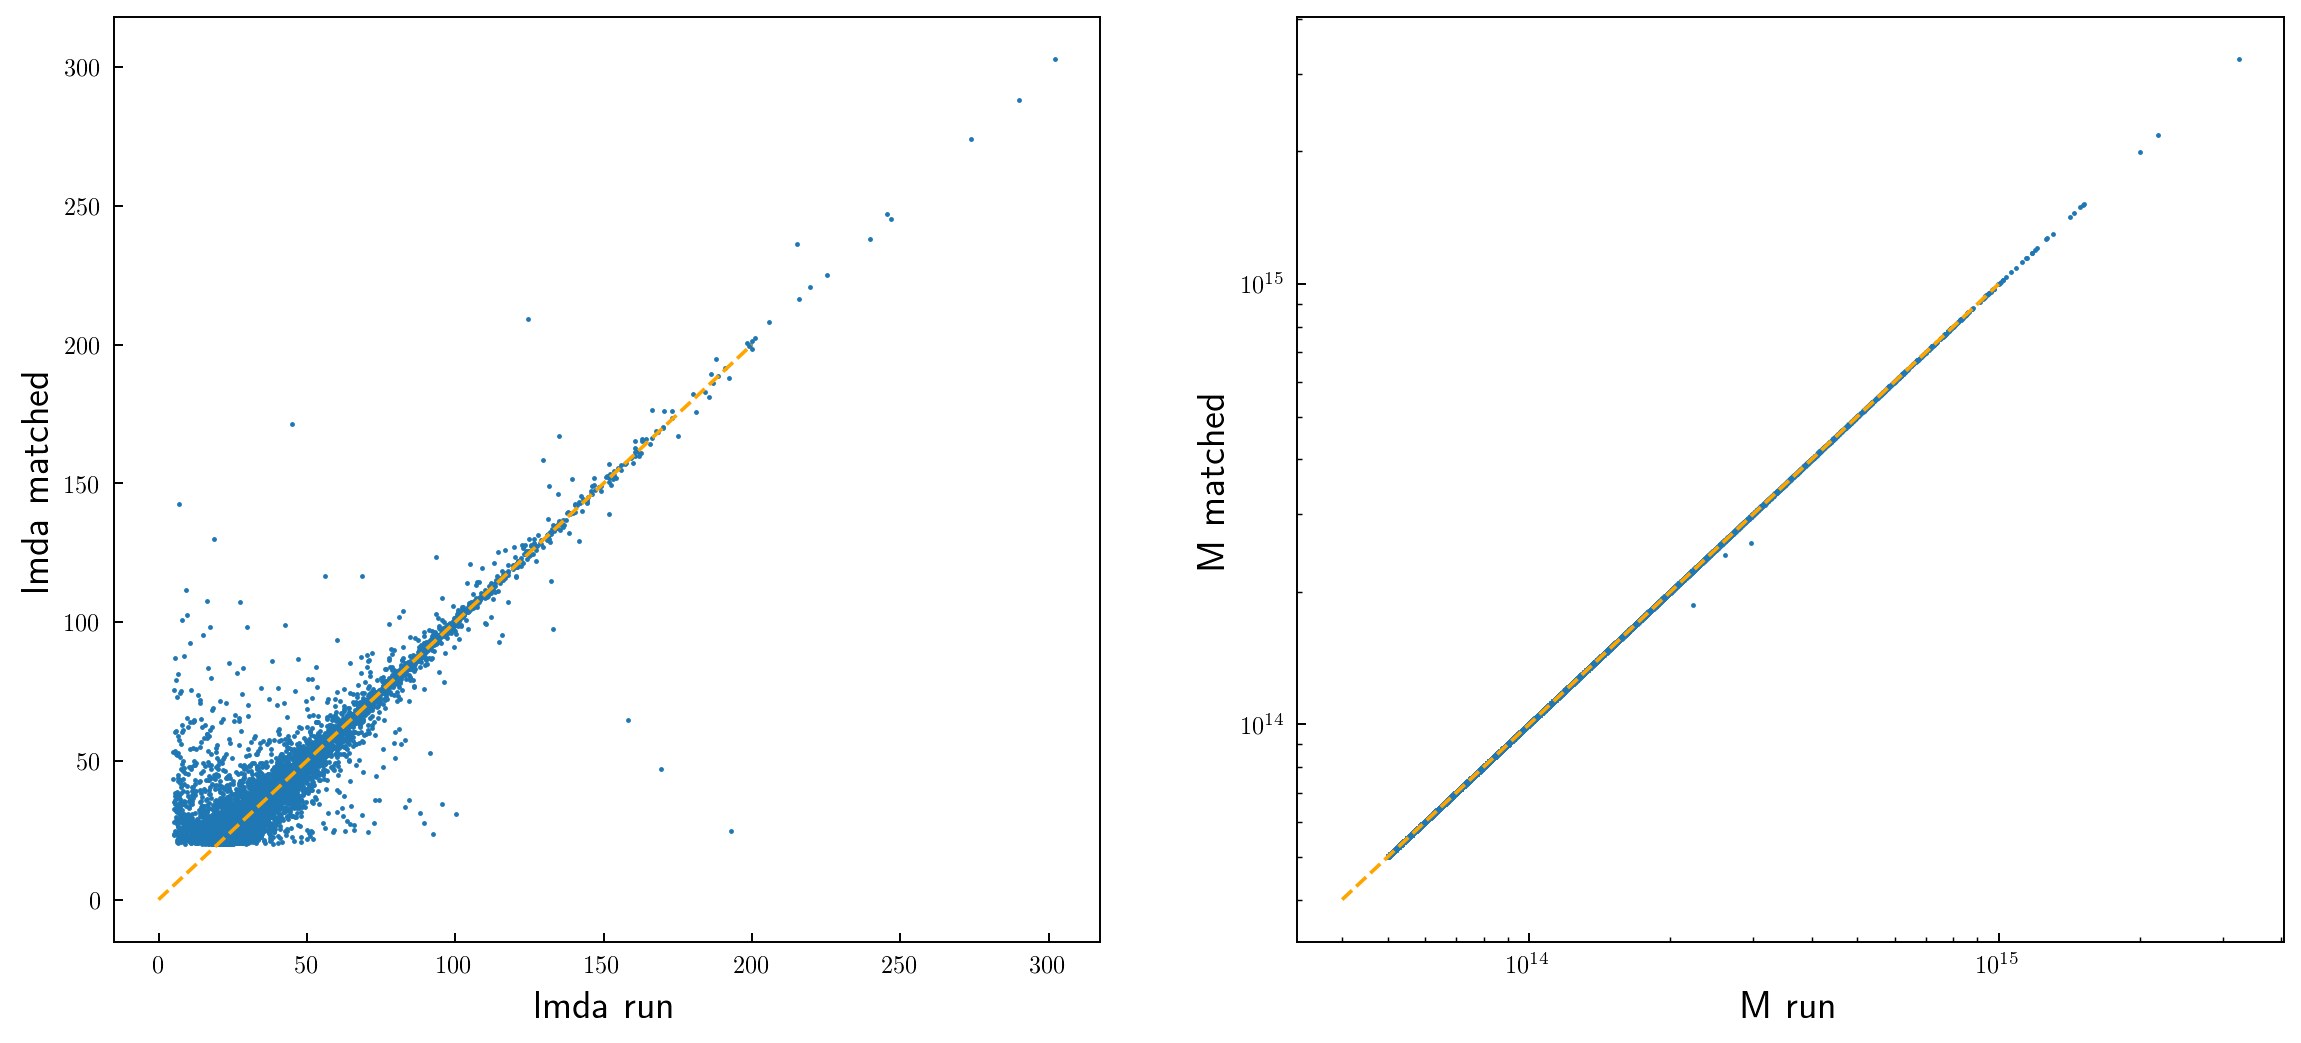

In [313]:
#np.random.shuffle(M_hrun)
#print M_hrun[0:10]
#print len(M_hrun), len(M_matched)

#Plotting
x_lmda = np.linspace(0,200,1000)
x_mass = np.linspace(4e13, 1e15, 1000)
fig, ax = plt.subplots(1,2, figsize = (16,7))
ax[0].scatter(hrun_data_halocut.LAMBDA_CHISQ, redM_halos_halocut.redM_lmda, s=1)
ax[0].plot(x_lmda, x_lmda, linestyle='--',color='orange')
ax[1].scatter(hrun_data_halocut.M200, redM_halos_halocut.halos_Mvir, s=1)
ax[1].plot(x_mass, x_mass, linestyle='--', color='orange')

ax[0].set_xlabel('lmda run', fontsize=16)
ax[0].set_ylabel('lmda matched', fontsize=16)

ax[1].set_xlabel('M run', fontsize=16)
ax[1].set_ylabel('M matched', fontsize=16)
ax[1].set_yscale('log'); ax[1].set_xscale('log')

plt.show()

#### Cluster miscentering from matched halos
There is some mismatch in the miscentering distribution of halos. I think the halos are properply matched, but there is difference in RA, DEC, and z. Wonder if that is enough to account for the difference in distribution?

In [314]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

#For the Chinchilla catalog
halos_matched_d = cosmo.comoving_distance(redM_halos_halocut.halos_z)
redM_coord = SkyCoord(redM_halos_halocut.redM_RA*u.deg, redM_halos_halocut.redM_DEC*u.deg, distance=halos_matched_d, frame='icrs')
halos_matched_coord = SkyCoord(redM_halos_halocut.halos_RA*u.deg, redM_halos_halocut.halos_DEC*u.deg, distance=halos_matched_d, frame='icrs')
miscenter_d_Chinchilla = halos_matched_coord.separation_3d(redM_coord)

#For the halo_run catalog
hrun_d = cosmo.comoving_distance(hrun_data_halocut.Z)
hrun_coord = SkyCoord(hrun_data_halocut.RA*u.deg, hrun_data_halocut.DEC*u.deg, distance=hrun_d, frame='icrs')
miscenter_d_hrun = hrun_coord.separation_3d(redM_coord)

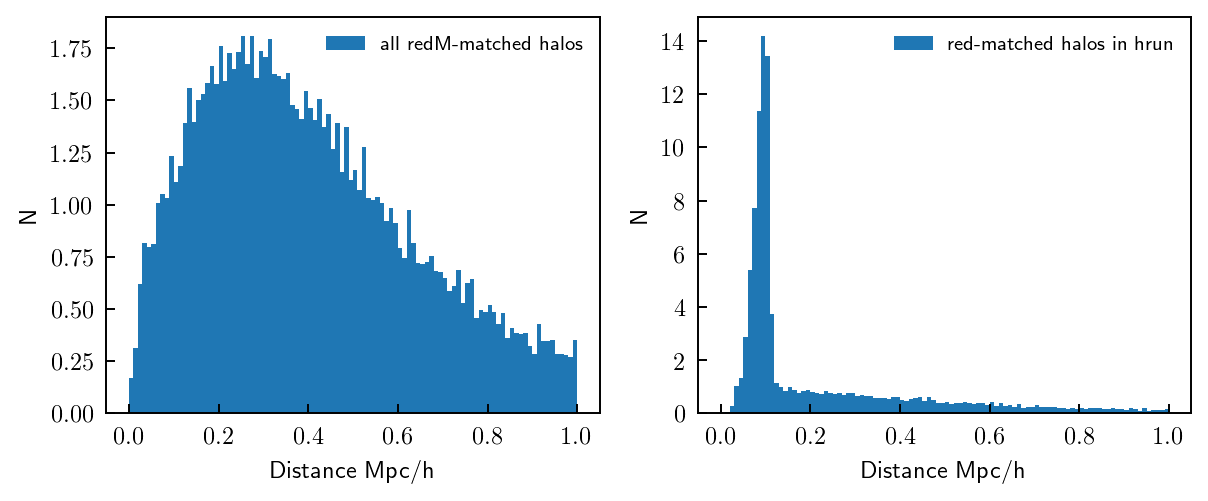

In [315]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
num_bin=100;
hist_range = (0,1)

#Plotting random halos
axs[0].hist(miscenter_d_Chinchilla, num_bin, range=hist_range, label='all redM-matched halos', density=True)
axs[1].hist(miscenter_d_hrun, num_bin, range=hist_range, label='red-matched halos in hrun', density=True)

#Plot config   
#axs[0].set_ylim((0,6000))
axs[0].set_xlabel('Distance Mpc/h')
axs[0].set_ylabel('N')
#axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)
axs[0].legend(loc='best', fontsize=8, frameon=False)

#axs[1].set_ylim((0,1000))
axs[1].set_xlabel(r'Distance Mpc/h')
axs[1].set_ylabel('N')
#axs[1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
axs[1].legend(loc='best', fontsize=8, frameon=False)
#plt.savefig('ellipticity_032018.png')
plt.show()

#### Diagnostics Test for Miscentering

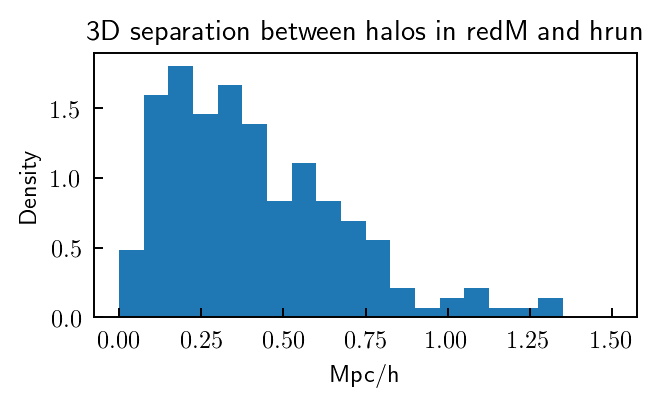

In [316]:
thin = 100
RA_diff = hrun_data_halocut.RA[::thin] - redM_halos_halocut.halos_RA[::thin]
RA_null = np.zeros_like(RA_diff)
DEC_diff = hrun_data_halocut.DEC[::thin] - redM_halos_halocut.halos_DEC[::thin]
DEC_null = np.zeros_like(DEC_diff)
halos_matched_d = cosmo.comoving_distance(redM_halos_halocut.halos_z[::thin])
diff_coord = SkyCoord(RA_diff*u.deg, DEC_diff*u.deg, distance=halos_matched_d, frame='icrs')
null_coord = SkyCoord(RA_null*u.deg, DEC_null*u.deg, distance=halos_matched_d, frame='icrs')
diff_d = diff_coord.separation_3d(null_coord)

num_bin=20;
hist_range = (0,1.5)
#Plotting random halos
plt.figure(figsize=(4,2))
plt.hist(diff_d, num_bin, range=hist_range, label='all redM-matched halos', density=True)
plt.ylabel('Density')
plt.xlabel('Mpc/h')
plt.title('3D separation between halos in redM and hrun')
plt.show()

#### $\Delta\lambda$ vs other parameters
Plot the 3D seperation with difference in lambda. 

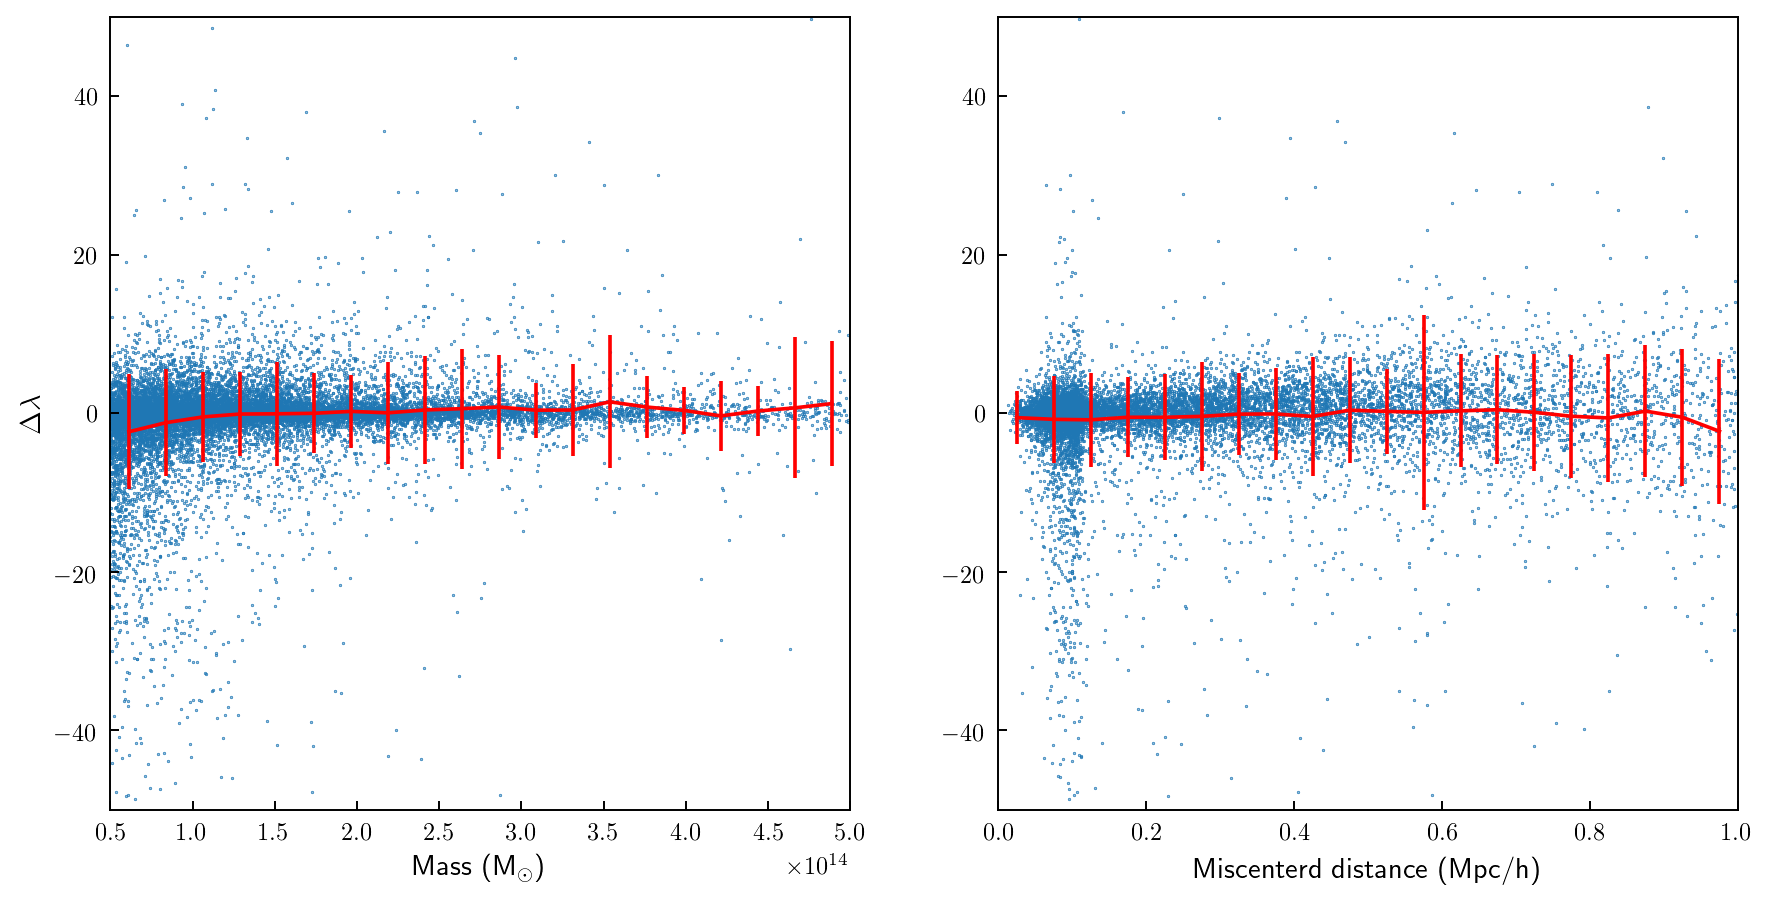

In [317]:
from scipy.stats import binned_statistic as bin_stat
delta_lambda = np.float64(hrun_data_halocut.LAMBDA_CHISQ - redM_halos_halocut.redM_lmda)

nbins = 20
dlmda_range = (-50,50)
#error for mass
m_range = (5e13,5e14)
n, _ = np.histogram(hrun_data_halocut.M200, bins=nbins, range=m_range)
sy, _ = np.histogram(hrun_data_halocut.M200, bins=nbins, weights=delta_lambda, range=m_range)
sy2, mass_bins = np.histogram(hrun_data_halocut.M200, bins=nbins, weights=delta_lambda**2., range=m_range)
lmda_mass_mean = sy / n
lmda_mass_std = np.sqrt(sy2/n - lmda_mass_mean**2.)

#error for miscentering
d_range = (0,1)
n, _ = np.histogram(miscenter_d_hrun, bins=nbins, range=d_range)
sy, d_bins = np.histogram(miscenter_d_hrun, bins=nbins, weights=delta_lambda, range=d_range)
sy2, d_bins = np.histogram(miscenter_d_hrun, bins=nbins, weights=delta_lambda**2., range=d_range)
lmda_d_mean = sy / n
lmda_d_std = np.sqrt(sy2/n - lmda_d_mean**2.)

fig, ax = plt.subplots(1,2, figsize = (12,6))
#plt.tight_layout()
#Scatter plots
ax[0].scatter(hrun_data_halocut.M200, delta_lambda, s=0.1)
ax[0].errorbar((mass_bins[1:] + mass_bins[:-1])/2, lmda_mass_mean, yerr=lmda_mass_std, fmt='r-')
ax[1].scatter(miscenter_d_hrun, delta_lambda, s=0.1)
ax[1].errorbar((d_bins[1:] + d_bins[:-1])/2, lmda_d_mean, yerr=lmda_d_std, fmt='r-')
ax[0].set_xlim(m_range)
ax[1].set_xlim(d_range)
ax[0].set_ylim(dlmda_range)
ax[1].set_ylim(dlmda_range)

ax[0].set_ylabel(r'$\Delta\lambda$', fontsize=12)
ax[0].set_xlabel(r'Mass (M$_\odot$)', fontsize=12)
ax[1].set_xlabel(r'Miscenterd distance (Mpc/h)', fontsize=12)

#Error plots
#For mass of hrun
#dLmda_mass_mean = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]
#dLmda_mass_stdev = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]

plt.show()

### Save halocut redM_halos onto a .dat file
Include the parameter hrun_lmda

In [ ]:
import numpy.lib.recfunctions as rfn
hrun_lambda = np.array(hrun_data_halocut.LAMBDA_CHISQ, dtype=[('hrun_lmda', 'f4')] )
print len(hrun_lmda)

assert len(hrun_lambda) == len(redM_halos_halocut), "Arrays have different number of halos"
arrays = [redM_halos_halocut, hrun_lambda]
redM_halos_halocut = rfn.merge_arrays(arrays, flatten = True, usemask = False) #Do it once only


In [344]:
#np.save("redM_halos_hruncut_mcut5e13", redM_halos_halocut)

In [357]:
print redM_halos_halocut.dtype
print redM_halos_halocut
redM_halos_halocut = redM_halos_halocut.view(np.recarray)

mass_sort = np.argsort(redM_halos_halocut.halos_M200b)
redM_msorted = redM_halos_halocut[mass_sort]
print "ID are ", redM_msorted['halos_ID'][:-10:-1], '\n'
print "Masses are", redM_msorted['halos_M200b'][:-10:-1], '\n'
print "Richnesss are", redM_msorted['redM_lmda'][:-10:-1], '\n'
print "RA are", redM_msorted['halos_RA'][:-10:-1], '\n'
print "DEC are", redM_msorted['halos_DEC'][:-10:-1], '\n'


(numpy.record, [('redM_ID', '<i4'), ('redM_RA', '<f8'), ('redM_DEC', '<f8'), ('redM_z', '<f8'), ('redM_lmda', '<f8'), ('halos_ID', '<i4'), ('halos_RA', '<f8'), ('halos_DEC', '<f8'), ('halos_z', '<f8'), ('halos_X', '<f8'), ('halos_Y', '<f8'), ('halos_Z', '<f8'), ('halos_M200b', '<f8'), ('halos_Mvir', '<f8'), ('halos_Rvir', '<f8'), ('hrun_lmda', '<f4')])
[( 64168, 318.5653418,  -2.1086008, 0.3513928, 20.2323098,    760306, 318.5680258,  -2.0969058, 0.3359408, 697.3832818, -615.5180978,  -34.0572628, 5.7633e+13, 5.4284e+13, 0.8597618, 19.881445)
 ( 24919, 316.2766658, -41.1176638, 0.3098978, 24.5799778,   2184825, 316.3227308, -41.1239718, 0.3177888, 481.8817318, -460.1305778, -581.7248848, 6.1518e+13, 5.6662e+13, 0.8688948, 29.263254)
 ( 42908, 315.7586218, -43.9880948, 0.3259438, 26.0597108,   2203138, 315.7576698, -43.9894578, 0.3328798, 475.7432458, -463.3244688, -641.0577378, 1.8733e+14, 1.7769e+14, 1.2757658, 26.074965)
 ...
 ( 28488,  79.7066228, -21.4783018, 0.6789608, 35.2584618,